# 가구원수별 가구수(구별) 분석 
## 2018년 데이터 사용

In [582]:
import time
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from glob import glob
import seaborn as sns
import json
import folium
import warnings
import requests
from urllib.parse import urlparse, quote
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

### CCTV 데이터 정리

In [583]:
cctv_Seoul = pd.read_excel("서울시 자치구 년도별 CCTV 설치 현황(2011년 이전_2018년).xlsx")
cctv_Seoul.rename(columns={cctv_Seoul.columns[0] : '구별'}, inplace=True)
cctv_Seoul['최근증가율'] = (cctv_Seoul['2018년'] + cctv_Seoul['2017년'] + cctv_Seoul['2016년'])/cctv_Seoul['2015년']*100
cctv_Seoul['구별'] = cctv_Seoul['구별'].str.replace(' ','')
cctv_Seoul = cctv_Seoul.set_index('구별')

### 서울 인구수 데이터 정리

In [584]:
pop_Seoul = pd.read_csv('report.txt',sep = "\t", engine='python',encoding='utf-8',thousands = ',')
pop_Seoul = pd.DataFrame({
    '구별':pop_Seoul['자치구'][2:],
    '인구수':pop_Seoul['인구'][2:],
    '한국인':pop_Seoul['인구.3'][2:],
    '외국인':pop_Seoul['인구.6'][2:],
    '고령자':pop_Seoul['65세이상고령자'][2:],
})
pop_Seoul = pop_Seoul.reset_index()
del pop_Seoul['index'] 
pop_Seoul = pop_Seoul.iloc[1:]
pop_Seoul = pop_Seoul.set_index('구별')
pop_Seoul['인구수'] = pop_Seoul['인구수'].apply(pd.to_numeric)
pop_Seoul['외국인'] = pop_Seoul['외국인'].apply(pd.to_numeric)
pop_Seoul['고령자'] = pop_Seoul['고령자'].apply(pd.to_numeric)
pop_Seoul['외국인비율'] = pop_Seoul['외국인'] / pop_Seoul['인구수'] * 100
pop_Seoul['고령자비율'] = pop_Seoul['고령자'] / pop_Seoul['인구수'] * 100
pop_Seoul.head()

,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,
종로구,159842,149952,9890,28396,6.187360,17.765043
중구,135321,125800,9521,24265,7.035863,17.931437
용산구,244953,229786,15167,39995,6.191800,16.327622
성동구,302695,295591,7104,45372,2.346917,14.989346
광진구,361923,348064,13859,50047,3.829268,13.828079


In [585]:
# str => num
for i in ['인구수','외국인','고령자']:
    pop_Seoul[i] = pop_Seoul[i].apply(pd.to_numeric)

### 2018 가구원수별 가구수(구별) 데이터 정리

In [586]:
hh_Seoul = pd.read_csv('가구원수별 가구수(구별).txt',sep = "\t", engine='python',encoding='utf-8',thousands = ',',header=1)
hh_Seoul = hh_Seoul.iloc[1:]
hh_Seoul = hh_Seoul.reset_index()
del hh_Seoul['기간']
hh_Seoul.rename(columns={hh_Seoul.columns[1] : '구별'}, inplace=True)
hh_Seoul = hh_Seoul.set_index('구별')
del hh_Seoul['index']


In [587]:
hh_Seoul.head()

,일반가구수,1인,2인,3인,4인,5인,6인,7인 이상,평균가구원수
구별,,,,,,,,,
종로구,63773,25326,15957,11241,8286,2228,573,162,2.2
중구,53102,20803,14101,9601,6463,1591,433,110,2.2
용산구,92500,34240,24574,17717,12098,3019,681,171,2.2
성동구,123963,40706,32135,26002,19548,4273,1035,264,2.3
광진구,148735,56337,35093,28596,22354,4947,1079,329,2.3


In [588]:
cctv_Seoul.head()

,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근증가율
구별,,,,,,,,,,
강남구,5221,1944.0,195.0,316.0,430,546,765,577,448,327.838828
강동구,1879,303.0,387.0,134.0,59,144,194,273,385,591.666667
강북구,1265,243.0,88.0,141.0,74,145,254,1,319,395.862069
강서구,1617,219.0,155.0,118.0,230,187,190,264,254,378.609626
관악구,3985,430.0,56.0,419.0,487,609,619,694,671,325.779967


In [589]:
pop_Seoul.head()

,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,
종로구,159842,149952,9890,28396,6.187360,17.765043
중구,135321,125800,9521,24265,7.035863,17.931437
용산구,244953,229786,15167,39995,6.191800,16.327622
성동구,302695,295591,7104,45372,2.346917,14.989346
광진구,361923,348064,13859,50047,3.829268,13.828079


In [590]:
hh_Seoul.head()

,일반가구수,1인,2인,3인,4인,5인,6인,7인 이상,평균가구원수
구별,,,,,,,,,
종로구,63773,25326,15957,11241,8286,2228,573,162,2.2
중구,53102,20803,14101,9601,6463,1591,433,110,2.2
용산구,92500,34240,24574,17717,12098,3019,681,171,2.2
성동구,123963,40706,32135,26002,19548,4273,1035,264,2.3
광진구,148735,56337,35093,28596,22354,4947,1079,329,2.3


## 가구별 분포

### 가구수별 분포도

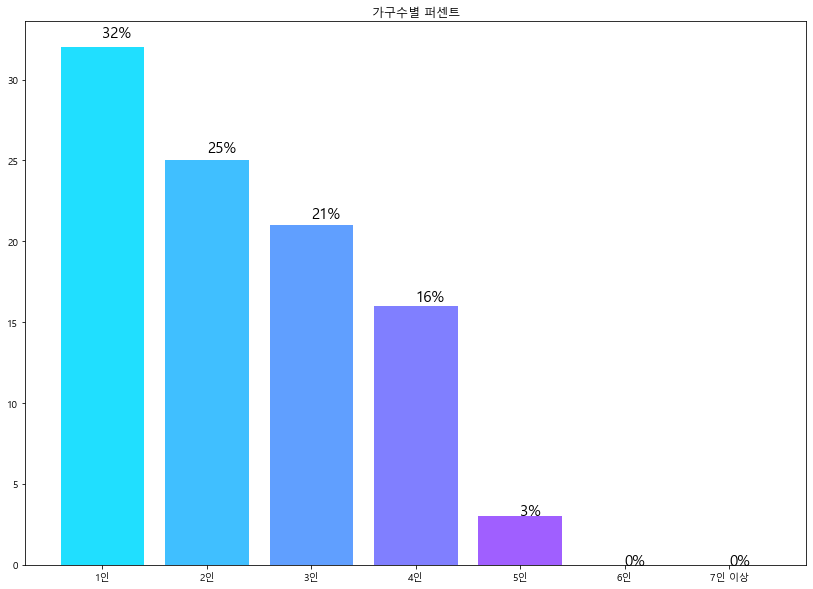

In [591]:
list_a = ['1인','2인','3인','4인','5인','6인','7인 이상']
per = [int((hh_Seoul[i].apply(pd.to_numeric).sum() / hh_Seoul['일반가구수'].sum())*100)  for i in list_a]
plt.figure(figsize=(14,10))
plt.title("가구수별 퍼센트")
colors = sns.color_palette('cool',len(per)) ## 색상 지정
plt.bar(list_a,per,color=colors)
for i in range(len(list_a)):
    plt.text(list_a[i],per[i]*1.02,str(per[i])+'%',fontsize=15)
# plt.colorbar()
# plt.grid()
plt.show()
# 1인가구 수가 제일 많음

### 일반 가구수 대비 1인가구 비율

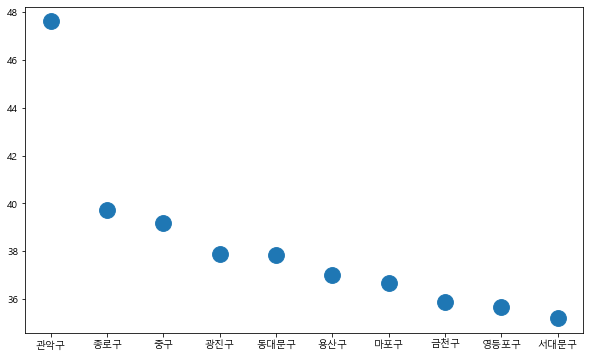

In [592]:
hh_Seoul['1인 가구 비율'] = (hh_Seoul['1인'] / hh_Seoul['일반가구수'])*100
hh_Seoul_sort_high = hh_Seoul.sort_values(by='1인 가구 비율',ascending=False)[:10]
plt.figure(figsize=(10,6))
plt.scatter(hh_Seoul_sort_high.index,hh_Seoul_sort_high['1인 가구 비율'],s=250)
plt.show()
# 관악구가 가구수대비 1인가구 비율이 높음

### 인구수와 조합

In [593]:
df_mer = pd.merge(pop_Seoul,hh_Seoul,on='구별')
del df_mer['평균가구원수']
df_mer['5인이상'] = df_mer['5인']+df_mer['6인']+df_mer['7인 이상']
del df_mer['5인']
del df_mer['6인']
del df_mer['7인 이상']
df_mer.head()

,인구수,한국인,외국인,고령자,외국인비율,고령자비율,일반가구수,1인,2인,3인,4인,1인 가구 비율,5인이상
구별,,,,,,,,,,,,,
종로구,159842,149952,9890,28396,6.187360,17.765043,63773,25326,15957,11241,8286,39.712731,2963
중구,135321,125800,9521,24265,7.035863,17.931437,53102,20803,14101,9601,6463,39.175549,2134
용산구,244953,229786,15167,39995,6.191800,16.327622,92500,34240,24574,17717,12098,37.016216,3871
성동구,302695,295591,7104,45372,2.346917,14.989346,123963,40706,32135,26002,19548,32.837218,5572
광진구,361923,348064,13859,50047,3.829268,13.828079,148735,56337,35093,28596,22354,37.877433,6355


In [594]:
df_mer[['고령자','외국인','인구수','1인','5인이상']].corr()
#1인과 외국인의 상관관계가 낮음
#인구수대비 1인가구수 상관관계가 높음

,고령자,외국인,인구수,1인,5인이상
고령자,1.000000,-0.208276,0.946895,0.629527,0.940344
외국인,-0.208276,1.000000,-0.170255,0.132770,-0.305816
인구수,0.946895,-0.170255,1.000000,0.663454,0.970578
1인,0.629527,0.132770,0.663454,1.000000,0.505743
5인이상,0.940344,-0.305816,0.970578,0.505743,1.000000


In [605]:
df_tmp = df_mer[['고령자','외국인','인구수','1인','5인이상']]
df_corr = df_tmp.corr()
df_corr

,고령자,외국인,인구수,1인,5인이상
고령자,1.000000,-0.208276,0.946895,0.629527,0.940344
외국인,-0.208276,1.000000,-0.170255,0.132770,-0.305816
인구수,0.946895,-0.170255,1.000000,0.663454,0.970578
1인,0.629527,0.132770,0.663454,1.000000,0.505743
5인이상,0.940344,-0.305816,0.970578,0.505743,1.000000


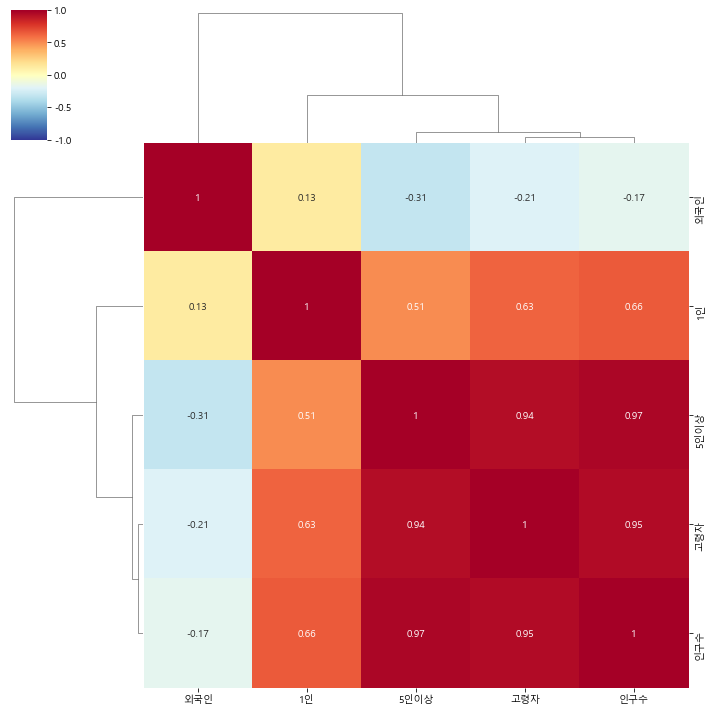

In [606]:
sns.clustermap(df_corr, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )
plt.show()

In [595]:
np.corrcoef(df_mer['인구수'],df_mer['1인'])
# 상관관계 있음

array([[1.       , 0.6634541],
       [0.6634541, 1.       ]])

In [596]:
np.corrcoef(df_mer['외국인비율'],df_mer['1인 가구 비율'])

array([[1.        , 0.59041633],
       [0.59041633, 1.        ]])

#### 인구수대비 1인가구수

In [597]:
fp1 = np.polyfit(df_mer['인구수'],df_mer['1인'],1)
f1 = np.poly1d(fp1)
fx = [100000,700000]

df_mer["인구수대비 1인 오차"] = np.abs(df_mer['1인'] - f1(df_mer['인구수']))
df_mer_sort = df_mer.sort_values(by='인구수대비 1인 오차',ascending=False)
df_mer_sort.head()

,인구수,한국인,외국인,고령자,외국인비율,고령자비율,일반가구수,1인,2인,3인,4인,1인 가구 비율,5인이상,인구수대비 1인 오차
구별,,,,,,,,,,,,,,
관악구,514555,498574,15981,78206,3.105790,15.198764,236761,112733,54106,35925,25997,47.614683,8000,52514.214258
양천구,460048,456240,3808,64804,0.827740,14.086356,162039,34304,40185,41534,36359,21.170212,9657,20745.676819
강동구,462275,458058,4217,68798,0.912228,14.882483,159233,42126,41450,36503,30197,26.455571,8957,13134.871814
송파구,676673,670331,6342,92149,0.937233,13.617951,243547,63451,61970,56824,48156,26.052877,13146,12142.060613
도봉구,329300,327248,2052,61388,0.623140,18.641968,126286,30848,35343,30077,23237,24.427094,6781,11802.339973


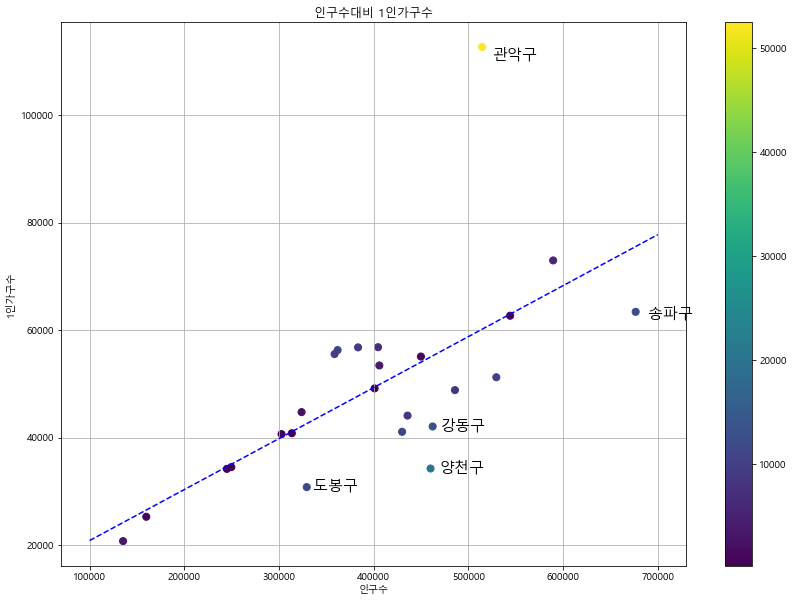

In [598]:
plt.figure(figsize=(14,10))
plt.scatter(df_mer['인구수'],df_mer['1인'],s=50,c=df_mer["인구수대비 1인 오차"])
plt.plot(fx,f1(fx),ls='dashed',color='b')
for n in range(5):
    plt.text(df_mer_sort['인구수'][n]*1.02, df_mer_sort['1인'][n]*0.98,
            df_mer_sort.index[n],fontsize=15)
plt.xlabel('인구수')
plt.ylabel('1인가구수')
plt.title("인구수대비 1인가구수")
plt.colorbar()
plt.grid()
plt.show()
# 관악구가 압도적으로 인구수대비 1인가구가 많았습니다 
# 1인가구 수와 다르게 종로는 인구수대비 1인가구가 평균치에
# 송파를 비롯한 구는 인구수대비 적은걸로 보여 2인이상의 가구가 많은것으로 보입니다

#### 5인이상 가구와 고령자비율의 상관관계

In [599]:
np.corrcoef(df_mer['고령자'],df_mer['5인이상'])


array([[1.        , 0.94034372],
       [0.94034372, 1.        ]])

In [600]:
fp1 = np.polyfit(df_mer['고령자'],df_mer['5인이상'],1)
f1 = np.poly1d(fp1)
fx = [14000,125000]

df_mer["고령자와 5인이상 오차"] = np.abs(df_mer['5인이상'] - f1(df_mer['고령자']))
df_mer_sort = df_mer.sort_values(by='고령자와 5인이상 오차',ascending=False)
df_mer_sort.head()

,인구수,한국인,외국인,고령자,외국인비율,고령자비율,일반가구수,1인,2인,3인,4인,1인 가구 비율,5인이상,인구수대비 1인 오차,고령자와 5인이상 오차
구별,,,,,,,,,,,,,,,
서초구,429995,426009,3986,59495,0.926988,13.836207,155418,41137,38475,35620,31029,26.468620,9157,11062.634981,2005.528041
관악구,514555,498574,15981,78206,3.105790,15.198764,236761,112733,54106,35925,25997,47.614683,8000,52514.214258,1788.824573
양천구,460048,456240,3808,64804,0.827740,14.086356,162039,34304,40185,41534,36359,21.170212,9657,20745.676819,1757.213946
강북구,313550,309996,3554,62951,1.133472,20.076862,127551,40872,34781,26543,19222,32.043653,6133,284.706760,1505.602024
송파구,676673,670331,6342,92149,0.937233,13.617951,243547,63451,61970,56824,48156,26.052877,13146,12142.060613,1391.881884


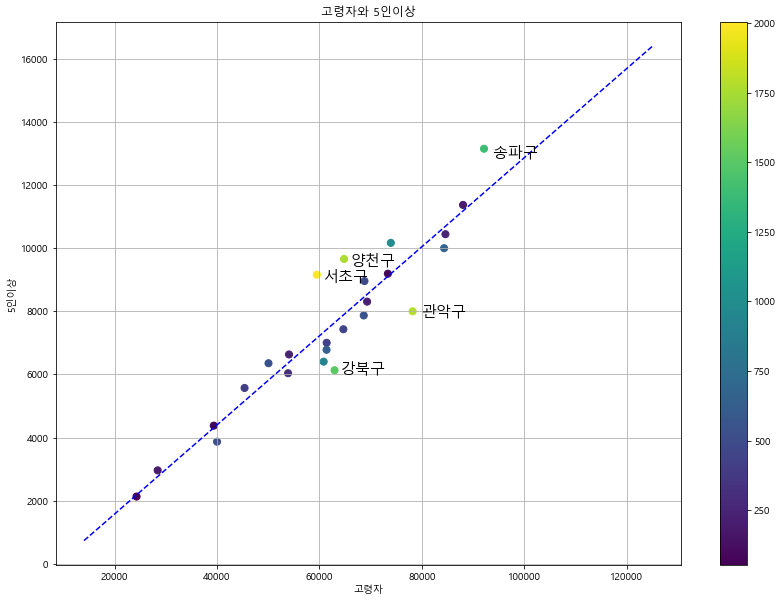

In [601]:
plt.figure(figsize=(14,10))
plt.scatter(df_mer['고령자'],df_mer['5인이상'],s=50,c=df_mer["고령자와 5인이상 오차"])
plt.plot(fx,f1(fx),ls='dashed',color='b')
for n in range(5):
    plt.text(df_mer_sort['고령자'][n]*1.02, df_mer_sort['5인이상'][n]*0.98,
            df_mer_sort.index[n],fontsize=15)
plt.xlabel('고령자')
plt.ylabel('5인이상')
plt.title("고령자와 5인이상")
plt.colorbar()
plt.grid()
plt.show()

#### 1인가구와 외국인의 상관관계

In [602]:
df_mer["1인가구와 외국인 오차"] = np.abs(df_mer['외국인비율'] - f1(df_mer['1인 가구 비율']))
df_mer_sort = df_mer.sort_values(by='1인가구와 외국인 오차',ascending=False)
fp1 = np.polyfit(df_mer['1인 가구 비율'],df_mer['외국인비율'],1)
f1 = np.poly1d(fp1)
fx = [20,60]
df_mer_sort.tail()


,인구수,한국인,외국인,고령자,외국인비율,고령자비율,일반가구수,1인,2인,3인,4인,1인 가구 비율,5인이상,인구수대비 1인 오차,고령자와 5인이상 오차,1인가구와 외국인 오차
구별,,,,,,,,,,,,,,,,
중랑구,400989,395997,4992,68658,1.244922,17.122165,159444,49207,42934,34055,25381,30.861619,7867,241.884189,576.015009,1231.361373
강서구,589536,583544,5992,88052,1.016393,14.935814,235754,73011,62155,50204,39017,30.969146,11367,5681.476992,190.362172,1231.117687
강북구,313550,309996,3554,62951,1.133472,20.076862,127551,40872,34781,26543,19222,32.043653,6133,284.706760,1505.602024,1231.083312
강남구,544085,539235,4850,73942,0.891405,13.590156,203083,62727,50076,43542,36572,30.887371,10166,292.229474,978.194696,1231.004226
관악구,514555,498574,15981,78206,3.105790,15.198764,236761,112733,54106,35925,25997,47.614683,8000,52514.214258,1788.824573,1230.860864


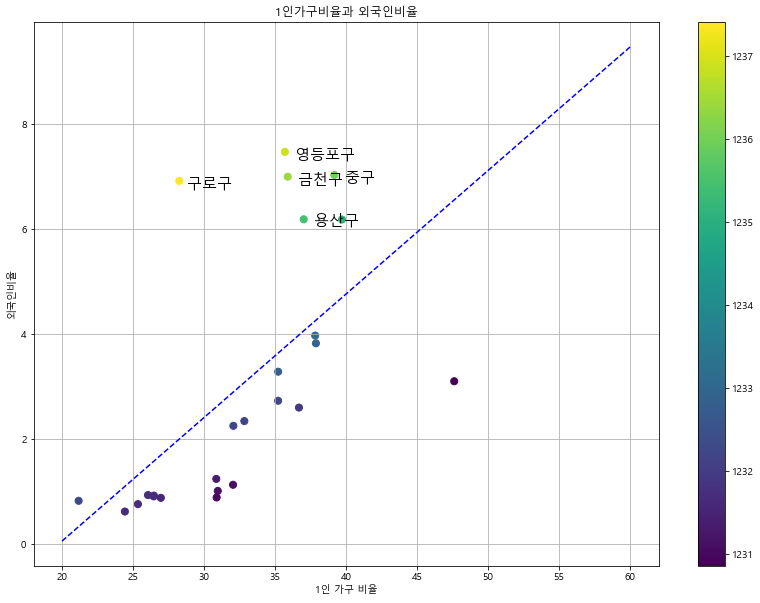

In [603]:
plt.figure(figsize=(14,10))
plt.scatter(df_mer['1인 가구 비율'],df_mer['외국인비율'],s=50,c=df_mer["1인가구와 외국인 오차"])
plt.plot(fx,f1(fx),ls='dashed',color='b')
for n in range(5):
    plt.text(df_mer_sort['1인 가구 비율'][n]*1.02, df_mer_sort['외국인비율'][n]*0.98,
            df_mer_sort.index[n],fontsize=15)
plt.xlabel('1인 가구 비율')
plt.ylabel('외국인비율')
plt.title("1인가구비율과 외국인비율")
plt.colorbar()
plt.grid()
plt.show()